# Supervised Learning - Breast Cancer Dataset
# Code available at https://github.com/cynthia-2802/ai-exam.git

## 1. Import Libraries

In [ ]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi
import numpy as np

import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score,
)
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Download the dataset from Kaggle API

In [2]:
api = KaggleApi()
api.authenticate()

path = "./data"
os.makedirs(path, exist_ok=True)
api.dataset_download_files("yasserh/breast-cancer-dataset", path=path)

zip_path = os.path.join(path, "breast-cancer-dataset.zip")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(path)

Dataset URL: https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset


## 3. Data Exploration

In [3]:
data = pd.read_csv("./data/breast-cancer.csv")

In [4]:
data.shape

(569, 32)

In [5]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [7]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


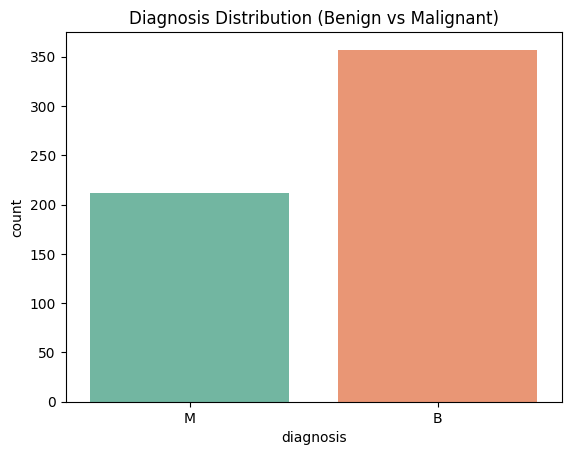

In [8]:
sns.countplot(x="diagnosis", data=data, hue="diagnosis", palette="Set2", legend=False)
plt.title("Diagnosis Distribution (Benign vs Malignant)")
plt.show()


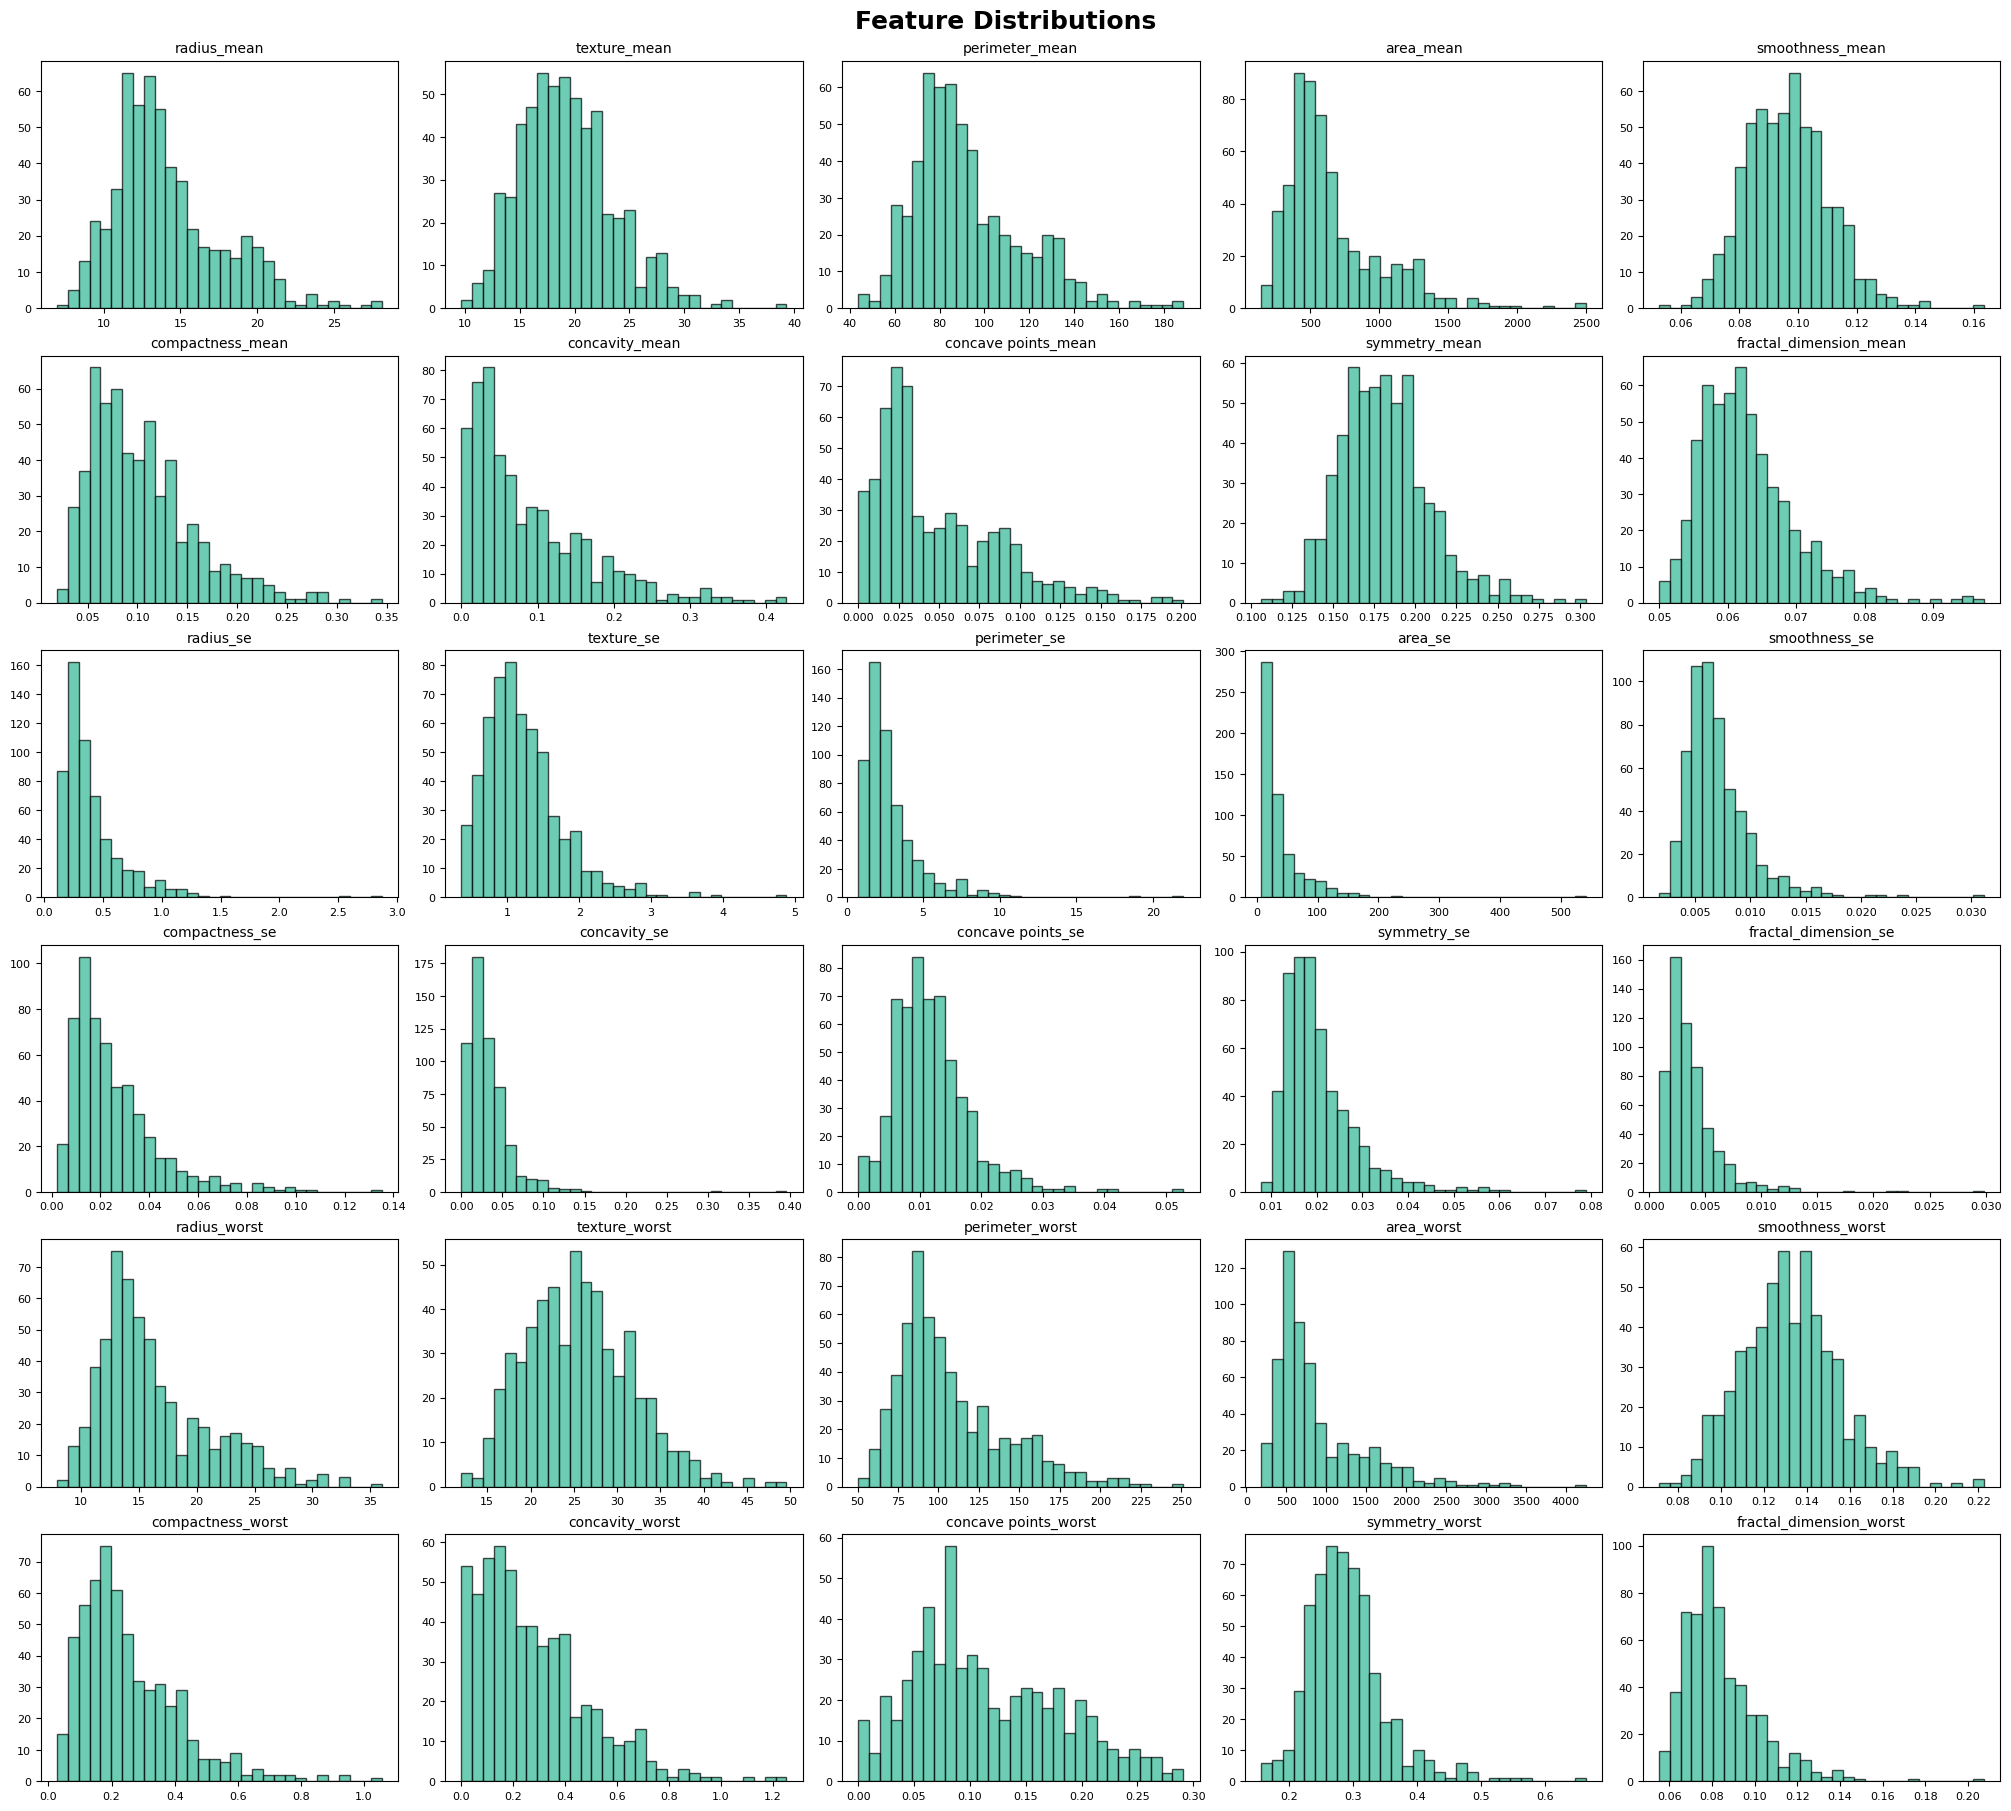

In [9]:
features = data.drop(columns=["id", "diagnosis"])

fig, axes = plt.subplots(
    nrows=6, ncols=5, figsize=(20, 18),
    constrained_layout=True
)

axes = axes.ravel()
n_features = len(features.columns)

for idx, col in enumerate(features.columns):
    axes[idx].hist(
        features[col],
        bins=30,
        color="#2FB994",
        edgecolor="black",
        alpha=0.7
    )
    axes[idx].set_title(col, fontsize=10)
    axes[idx].tick_params(axis="x", labelsize=8)
    axes[idx].tick_params(axis="y", labelsize=8)

for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Feature Distributions", fontsize=18, weight="bold")
plt.show()


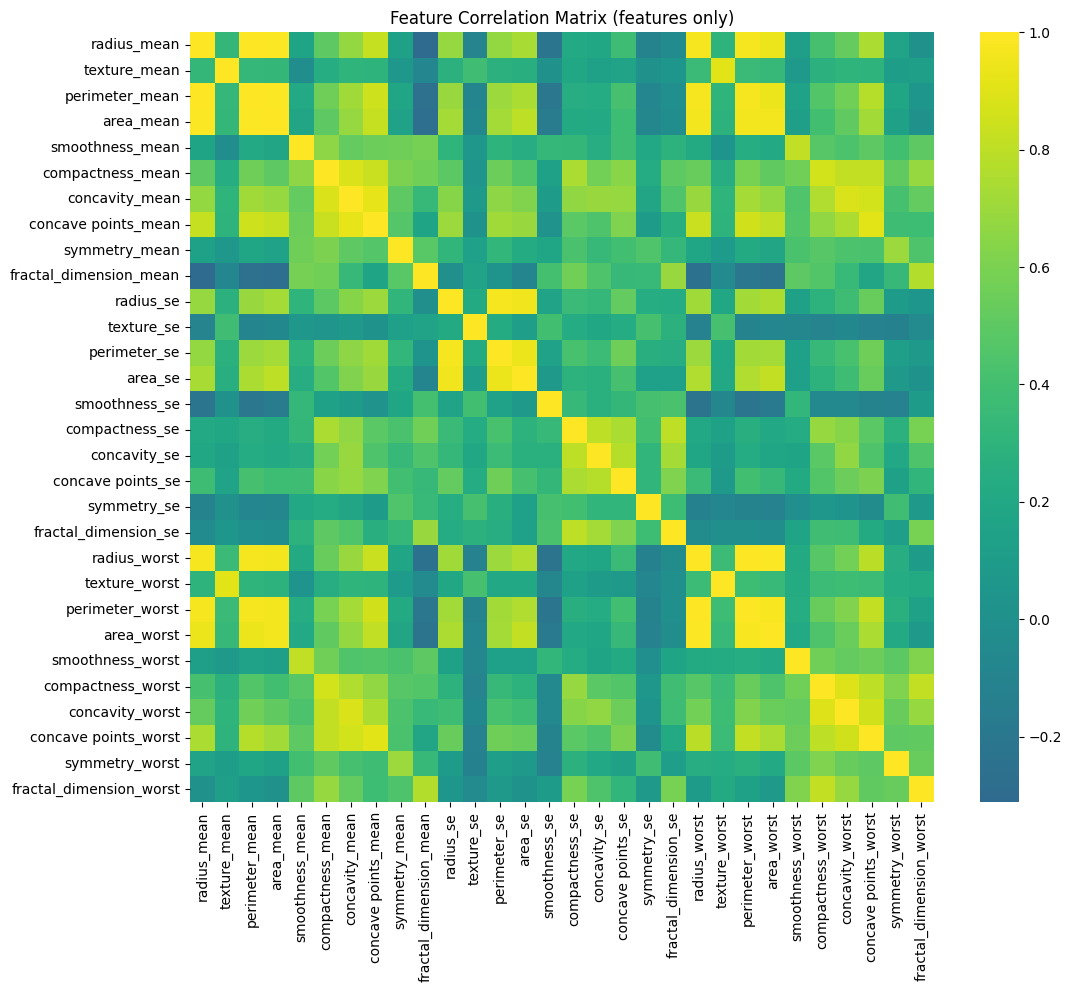

In [10]:
num = data.drop(columns=["id", "diagnosis"]).select_dtypes(include="number")
plt.figure(figsize=(12,10))
sns.heatmap(num.corr(), cmap="viridis", center=0)
plt.title("Feature Correlation Matrix (features only)")
plt.show()


## 4. Model Training and Evaluation

In [11]:
data["diagnosis"] = data["diagnosis"].map({"B": 0, "M": 1})

X = data.drop(columns=["diagnosis"])
y = data["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f}")

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")


Mean CV ROC-AUC: 0.9940
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Test ROC-AUC: 0.9970


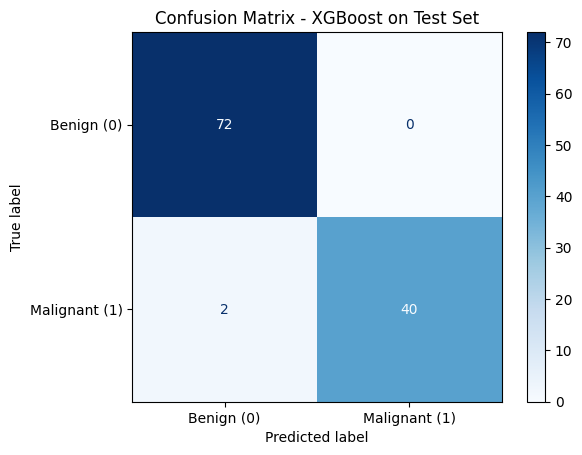

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Malignant (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - XGBoost on Test Set")
plt.show()



Default at threshold=0.500000
              precision    recall  f1-score   support

           0     0.9730    1.0000    0.9863        72
           1     1.0000    0.9524    0.9756        42

    accuracy                         0.9825       114
   macro avg     0.9865    0.9762    0.9810       114
weighted avg     0.9829    0.9825    0.9824       114



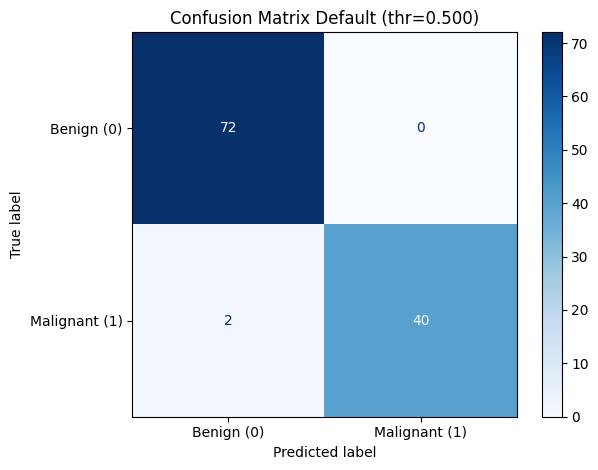


Candidate low threshold (ROC, recall=1.0): 0.015134

Recall-Prioritized at threshold=0.015134
              precision    recall  f1-score   support

           0     1.0000    0.8750    0.9333        72
           1     0.8235    1.0000    0.9032        42

    accuracy                         0.9211       114
   macro avg     0.9118    0.9375    0.9183       114
weighted avg     0.9350    0.9211    0.9222       114



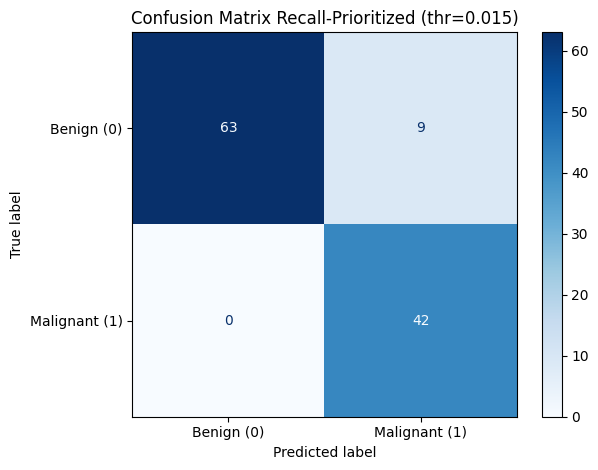

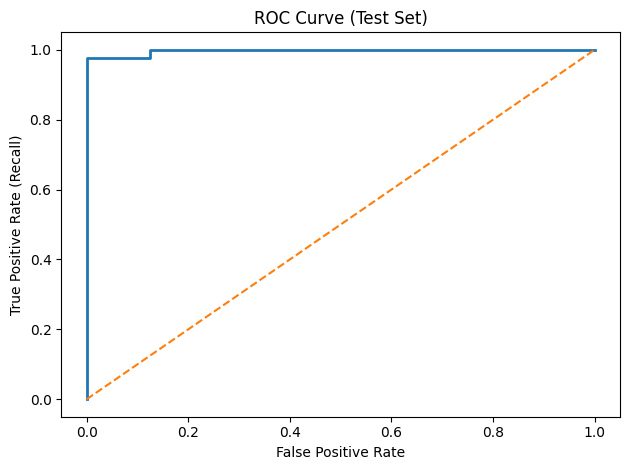

In [13]:
def evaluate_at_threshold(
    y_true, y_proba, threshold: float, title: str = ""
) -> None:
    """
    Evaluate a binary classifier at a given probability threshold.

    Args:
        y_true: True binary labels (0/1).
        y_proba: Predicted probabilities for the positive class (shape: [n]).
        threshold: Probability cutoff for predicting class 1.
        title: Title suffix for plots/prints.
    """
    y_pred = (y_proba >= threshold).astype(int)
    print(f"\n{title} at threshold={threshold:.6f}")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    ConfusionMatrixDisplay(cm, display_labels=["Benign (0)", "Malignant (1)"]).plot(
        cmap="Blues", values_format="d"
    )
    plt.title(f"Confusion Matrix {title} (thr={threshold:.3f})")
    plt.tight_layout()
    plt.show()

evaluate_at_threshold(y_test, y_proba, threshold=0.5, title="Default")

fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
idx_recall_1 = np.where(tpr >= 1.0 - 1e-12)[0]
thr_recall_1 = float(roc_thresholds[idx_recall_1[0]]) if len(idx_recall_1) else float(roc_thresholds[-1])

print(f"\nCandidate low threshold (ROC, recall=1.0): {thr_recall_1:.6f}")

evaluate_at_threshold(y_test, y_proba, threshold=thr_recall_1, title="Recall-Prioritized")

plt.figure()
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], ls="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Test Set)")
plt.tight_layout()
plt.show()
